# Stock Trading Strategy using Machine Learning (Linear Regression, KNN, Random Forest and SVM) - A comparision study 




## Introduction:
The goal of this project is to develop a stock trading strategy using the predictions obtained from a learning algorithm. The developed learner predicts the change in stock price over the next five trading days using Linear Regression, Random Forest, KNN and SVM. Bollinger Bands, Momentum, Volatility and .... are the input features and the prediction is for the stock price after five trading days. Analysis was done on IBM,... data. Based on the predictions made, the system is expected to suggest a position of 100 shares long, 100 share short or no action. The process was started with a cash of $10,000.
***

### <font color =blue>Operation 1: Data collection and pruning</font>
1. Read data from .csv file obtained from yahoo finance. 
2. The files downloaded were chosen to have data for an additional month before and beyond the start and end dates respectively
3. Adj. Close data column was selected for our current analysis.
4. Forward and backward fill was performed for missing data
5. Adj. Close data was plotted for our understanding


              ML4T-220
Date                  
2012-09-13  329.521872
2012-09-12  332.448452
2012-09-11  335.245408
2012-09-10  337.788858
2012-09-07  339.966147


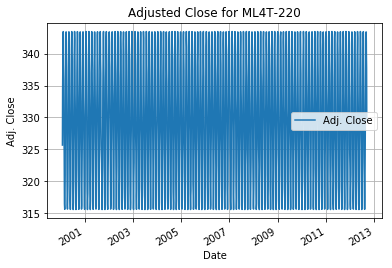

In [621]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime as dt
import pandas as pd

sd = dt.datetime(2007,11,30) 
ed = dt.datetime(2012,1,31)
syms=['ML4T-220']
dates = pd.date_range(sd, ed)
dfAdj = pd.DataFrame(index=dates)
dfAdj = pd.read_csv(syms[0] + '.csv', index_col="Date", parse_dates=True, usecols=['Date', 'Adj Close'],na_values=['NaN'])    # Reading files from the data/xxx.csv. Also replacing missing values with NANs
dfAdj.head()
dfAdj = dfAdj.rename(columns={'Adj Close': syms[0]})     # Renaming the Adj Close column to the symbol
# Forward Fill / Back Fill
dfAdj.fillna(method='ffill', inplace=True)
dfAdj.fillna(method='bfill', inplace=True)
dfAdj = dfAdj.dropna()
print(dfAdj.head())



pl1 = dfAdj.plot(y=syms[0],label='Adj. Close',title='Adjusted Close for '+syms[0],fontsize=10)
plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()
plt.show()


### <font color =blue>Operation 2: Feature Generation and Selection</font>
#### <font color =green>2a. Bollinger Bands</font>
Bollinger Bands is a technical analysis tool with two standard deviations sandwiching the Simple Moving Average (SMA) of a stock price. SMA is computed for a 20 day window along with the standard deviation for the same window. This band has three lines. 
1. The middle one for SMA values
2. The top and bottom ones are SMA +/- 2 standard deviations for the same moving window.
Typically, the average of first 20 days of data is considered for the 21st day average and the next days average is from day 2 to day 21 and so on. 

    - $ BU =SMA(Price,w) + 2* \sigma[Price,w]$
    - $ BL =SMA(Price,w) - 2* \sigma[Price,w]$
    - $ \sigma [Price,w]->$ Standard Deviation of the data in the window w
    - $ SMA(Price,w) ->$ Simple Moving Average
    
Further we normalize these values to bring the feature on the same scale as others. (Also called the 
[% B indicator](https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:bollinger_band_perce))
For the current work, additional one month data prior to the training window was considered inorder to accommodate a moving window for 20 days. Otherwise, around 20 data points are lost.

-0.8251336961004688
0.8255377048597492
                MVA_20     StdA_20     StdB_20    Std_20    ML4T-220  \
Date                                                                   
2012-09-13         NaN         NaN         NaN       NaN  329.521872   
2012-09-12         NaN         NaN         NaN       NaN  332.448452   
2012-09-11         NaN         NaN         NaN       NaN  335.245408   
2012-09-10         NaN         NaN         NaN       NaN  337.788858   
2012-09-07  334.994147  343.302016  326.686279  4.153934  339.966147   
2012-09-06  337.425941  344.789271  330.062610  3.681665  341.680839   
2012-09-05  339.507648  345.612726  333.402569  3.052539  342.856987   
2012-09-04  341.147066  345.745965  336.548166  2.299450  343.442497   
2012-08-31  342.271581  345.217259  339.325904  1.472839  343.411436   
2012-08-30  342.831388  344.259222  341.403553  0.713917  342.765180   
2012-08-29  342.801690  344.350249  341.253132  0.774279  341.532352   
2012-08-28  342.183804  3

C:\Users\so51713\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


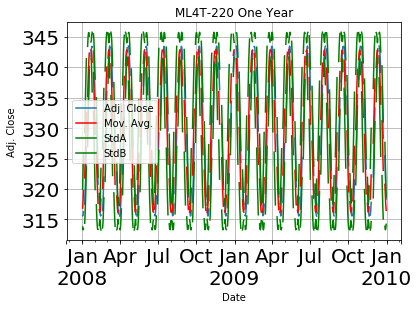

In [622]:
bolBand=pd.DataFrame()
wndwSize=5

bolBand['MVA_20']=dfAdj[syms[0]].rolling(window=wndwSize).mean()
bolBand['StdA_20']=bolBand['MVA_20']+2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['StdB_20']=bolBand['MVA_20']-2*dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand['Std_20']=dfAdj[syms[0]].rolling(window=wndwSize).std()
bolBand[syms[0]]=dfAdj[syms[0]]
bolBand['BolNorm_20']=(bolBand[syms[0]]-bolBand['MVA_20'])/(2*bolBand['Std_20'])
print(bolBand['BolNorm_20'].min())
print(bolBand['BolNorm_20'].max())


print(bolBand)

mastData=bolBand
# We are reducing bolBand for visualizationin graphs
dfRange=pd.date_range(start='2007-12-31',end='2009-12-31',closed=None)

bolBand=bolBand.loc[dfRange]#:dt.datetime(2008,1,31)
print(bolBand.head())
ax=plt.figure(1)
ax=plt.gca()
bolBand.plot(y=syms[0],label='Adj. Close',title=syms[0],fontsize=20,ax=ax)
bolBand.plot(y='MVA_20',label='Mov. Avg.',title=syms[0],fontsize=20,color='red',ax=ax)
bolBand.plot(y='StdA_20',label='StdA',title=syms[0],fontsize=20,color='green',ax=ax)
bolBand.plot(y='StdB_20',label='StdB',title=syms[0] + ' One Year',fontsize=20,color='green',ax=ax)



plt.xlabel("Date")
plt.ylabel("Adj. Close")
plt.grid()


#### <font color =green> 2b. Momentum </font>
Momentum indicates stock price strength. It indicates how fast or slow the stock prices change. It is just a difference of stock values over a window.
- Simply given as $ Momentum = P - P_n$
- where, P is current price and $P_n$ is the closing price before 'n' trading days.

In the current process, we considered momentum across various windows, expecting to use them as features for training our ML algorithms.
From the correlation values obtained below in results, momentum with 20 window was found to have a higher value, hence we plan to use a 20 point window for our ML training.

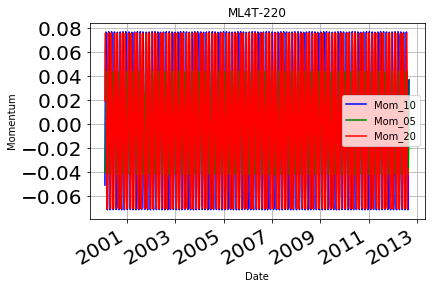

In [623]:
#print(bolBand['Date'])

mNSize=10;
mNSize1=5;
mNSize2=20;
momentum=mastData.reset_index()
momentum['Mom_10']=np.nan
momentum['Mom_05']=np.nan
momentum['Mom_20']=np.nan
momentum['Mom_01']=np.nan
for x in range(mNSize,momentum[syms[0]].count()):
    momentum.at[x,'Mom_10']= (momentum.loc[x,[syms[0]]])/ (momentum.loc[x-mNSize,[syms[0]]])-1
    
for x in range(mNSize1,momentum[syms[0]].count()):
    momentum.at[x,'Mom_05']= (momentum.loc[x,[syms[0]]]-momentum.loc[x-mNSize1,[syms[0]]])/ (momentum.loc[x-mNSize1,[syms[0]]])

for x in range(mNSize2,momentum[syms[0]].count()):
    momentum.at[x,'Mom_20']= (momentum.loc[x,[syms[0]]])/ (momentum.loc[x-mNSize2,[syms[0]]])-1
    
for x in range(mNSize2,momentum[syms[0]].count()):
    momentum.at[x,'Mom_01']= (momentum.loc[x,[syms[0]]])/ (momentum.loc[x-1,[syms[0]]])-1
#momentum=momentum.set_index('Date')


ax1=plt.figure(2)
ax1=plt.gca()


momentum=momentum.set_index('Date')
momentum.plot(y='Mom_10',label='Mom_10',title=syms[0],fontsize=20,color='blue',ax=ax1)
momentum.plot(y='Mom_05',label='Mom_05',title=syms[0],fontsize=20,color='green',ax=ax1)
momentum.plot(y='Mom_20',label='Mom_20',title=syms[0],fontsize=20,color='red',ax=ax1)

#mastData['Mom_20']=momentum['Mom_20']
mastData[['Mom_20','Mom_10','Mom_05']]=momentum[['Mom_20','Mom_10','Mom_05']]
plt.xlabel("Date")
plt.ylabel("Momentum")
plt.grid()


Relative Strength Index

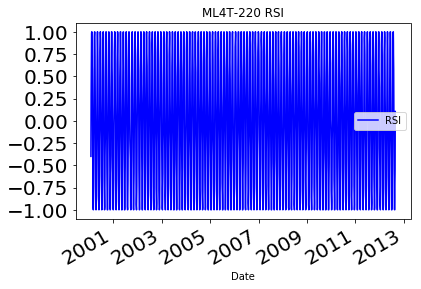

In [624]:
dfDummy=mastData
dfDummy=dfDummy.reset_index()
dfDummy=dfDummy[['Date',syms[0]]]
dfDummy['SD']=dfDummy[syms[0]].diff()
for x in range(1,dfDummy[syms[0]].count()):
    if dfDummy.loc[x,'SD']>=0:
        dfDummy.at[x,'Profits']=dfDummy.loc[x,'SD']
        dfDummy.at[x,'Loss']=0
    elif dfDummy.loc[x,'SD']<0:
        
        dfDummy.at[x,'Profits']=0
        dfDummy.at[x,'Loss']=abs(dfDummy.loc[x,'SD'])

dfDummy['ProfitAvg_14']=dfDummy['Profits'].rolling(window=14).sum()/14
dfDummy['LossAvg_14']=dfDummy['Loss'].rolling(window=14).sum()/14
dfDummy['RS_14']=dfDummy['ProfitAvg_14']/dfDummy['LossAvg_14']
dfDummy['RSI']=2*(1-1/(1+dfDummy['RS_14']))-1

axRSI=plt.figure(2)
axRSI=plt.gca()
dfDummy=dfDummy.set_index('Date')
dfDummy.plot(y='RSI',label='RSI',title=syms[0]+' RSI',fontsize=20,color='blue',ax=axRSI)
mastData['RSI_14']=dfDummy['RSI']
mastData['RS_14']=dfDummy['RS_14']
#dfDummy.plot(y=syms[0],label='IBM',title=syms[0]+' RSI',fontsize=20,color='blue',ax=axRSI)
#print(dfDummy)


                MVA_20     StdA_20     StdB_20    Std_20    ML4T-220  \
Date                                                                   
2012-09-13         NaN         NaN         NaN       NaN  329.521872   
2012-09-12         NaN         NaN         NaN       NaN  332.448452   
2012-09-11         NaN         NaN         NaN       NaN  335.245408   
2012-09-10         NaN         NaN         NaN       NaN  337.788858   
2012-09-07  334.994147  343.302016  326.686279  4.153934  339.966147   

            BolNorm_20  Mom_20  Mom_10  Mom_05  RSI_14  RS_14  Y_5  
Date                                                                
2012-09-13         NaN     NaN     NaN     NaN     NaN    NaN  NaN  
2012-09-12         NaN     NaN     NaN     NaN     NaN    NaN  NaN  
2012-09-11         NaN     NaN     NaN     NaN     NaN    NaN  NaN  
2012-09-10         NaN     NaN     NaN     NaN     NaN    NaN  NaN  
2012-09-07    0.598469     NaN     NaN     NaN     NaN    NaN  NaN  


,Mom_05,Mom_10,Mom_20,Y_5
Mom_05,1.000000,0.863634,-0.011596,0.493327
Mom_10,0.863634,1.000000,0.492650,-0.011238
Mom_20,-0.011596,0.492650,1.000000,-0.874357
Y_5,0.493327,-0.011238,-0.874357,1.000000


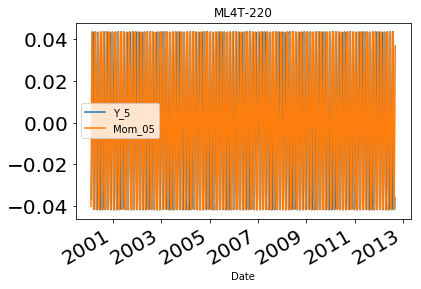

In [625]:
daysAhead=5;


mastData['Y_5']=np.nan
mastData=mastData.reset_index()
for x in range(mNSize,mastData[syms[0]].count()-daysAhead-1):
    mastData.at[x,'Y_5']= (mastData.loc[x+daysAhead,[syms[0]]])/ (mastData.loc[x,[syms[0]]])-1
ax2=plt.figure()
ax2=plt.gca()
mastData=mastData.set_index('Date')


print(mastData.head())
mastData.plot(y='Y_5',label='Y_5',title=syms[0],fontsize=20,ax=ax2)
mastData.plot(y='Mom_05',label='Mom_05',ax=ax2)
dfCorr=mastData[['Mom_05','Mom_10','Mom_20','Y_5']]
dfCorr.corr(method='pearson')

Separating Data

         MVA_20     StdA_20     StdB_20    Std_20    ML4T-220  BolNorm_20  \
726  323.054765  331.030715  315.078816  3.987975  328.359759    0.665124   
727  320.749015  327.650142  313.847887  3.450564  325.469039    0.683950   
728  318.831831  324.367705  313.295957  2.767937  322.757827    0.709192   
729  317.388129  321.344354  313.431904  1.978113  320.346207    0.747702   
730  316.481855  318.777521  314.186188  1.147833  318.340995    0.809848   

       Mom_20    Mom_10    Mom_05    RSI_14     RS_14       Y_5  
726 -0.040820  0.032097  0.036388  0.012830  1.025994  0.038692  
727 -0.051726  0.016765  0.030346 -0.217154  0.643177  0.042057  
728 -0.060398  0.000880  0.022877 -0.434629  0.394088  0.043578  
729 -0.066502 -0.014798  0.014348 -0.627522  0.228862  0.043138  
730 -0.069792 -0.029552  0.005190 -0.785973  0.119838  0.040714  
Training Features Shape: (731, 4)
Training Labels Shape: (731,)
Testing Features Shape: (731, 4)
Testing Labels Shape: (731,)


C:\Users\so51713\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
C:\Users\so51713\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


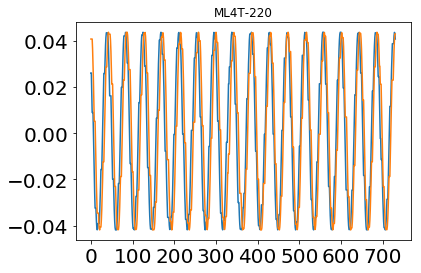

In [626]:
dfMLDataTrain=mastData



dfRangeTrain=pd.date_range(start='2008-1-1',end='2009-12-31',closed=None)
dfMLDataTrain=dfMLDataTrain.loc[dfRangeTrain]

dfMLDataTrain=dfMLDataTrain.reset_index()

dfMLDataTrain=dfMLDataTrain.drop(columns='index')


dfMLDataTrain=dfMLDataTrain.replace([np.inf, -np.inf], np.nan)

dfMLDataTrain=dfMLDataTrain.fillna(method='ffill')
dfMLDataTrain=dfMLDataTrain.fillna(method='bfill')
dfMLDataTrain=dfMLDataTrain.dropna()
dfTrainingX=dfMLDataTrain[['BolNorm_20','Mom_05','RS_14','RSI_14']]
dfTrainingY=dfMLDataTrain['Y_5']
print(dfMLDataTrain.tail())
#print("Training Data")
#print(dfTrainingX.head())


# Testing Data

dfMLDataTest=mastData



dfRangeTest=pd.date_range(start='2009-12-31',end='2011-12-31',closed=None)
dfMLDataTest=dfMLDataTest.loc[dfRangeTest]

dfMLDataTest=dfMLDataTest.reset_index()
dfMLDataTest=dfMLDataTest.drop(columns='index')

dfMLDataTest=dfMLDataTest.replace([np.inf, -np.inf], np.nan)

dfMLDataTest=dfMLDataTest.fillna(method='ffill')
dfMLDataTest=dfMLDataTest.fillna(method='bfill')
dfMLDataTest=dfMLDataTest.dropna()
dfTestingX=dfMLDataTest[['BolNorm_20','Mom_05','RS_14','RSI_14']]
dfTestingY=dfMLDataTest['Y_5']


axTr=plt.figure()
axTr=plt.gca()

dfTrainingY.plot(y='Y_5',label='Training',title=syms[0],fontsize=20,ax=axTr)
dfTestingY.plot(y='Y_5',label='Testing',ax=axTr)




print('Training Features Shape:', dfTrainingX.shape)
print('Training Labels Shape:', dfTrainingY.shape)
print('Testing Features Shape:', dfTestingX.shape)
print('Testing Labels Shape:', dfTestingY.shape)


Train Model

False
False
-0.003008304917484023
The coefficient for BolNorm_20 is -0.003008304917484023
The coefficient for Mom_05 is 1.1829607892475327
The coefficient for RS_14 is 2.2600973336216414e-06
The coefficient for RSI_14 is -0.0450093678048208
The intercept for our model is -0.00015764835699701147
Training MSE is 0.0013165930490697734
        Y_5
0  0.038922
1  0.038922
2  0.038922
3  0.038922
4  0.033813


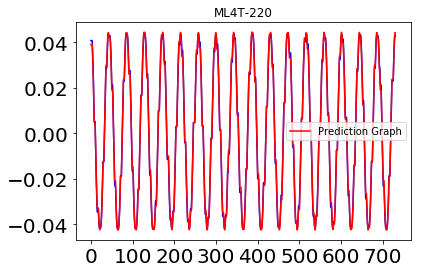

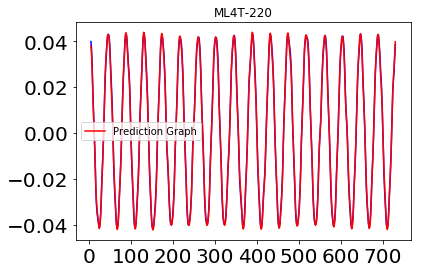

In [627]:
regression_model=LinearRegression()
print(dfTrainingY.isnull().values.any())
print(dfTrainingY.isnull().values.any())
regression_model.fit(dfTrainingX,dfTrainingY)

print(regression_model.coef_[0])
for idx, col_name in enumerate(dfTrainingX.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))
intercept=regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

regression_model.score(dfTrainingX,dfTrainingY)

from sklearn.metrics import mean_squared_error
predictY=regression_model.predict(dfTestingX)
regression_model_mse=mean_squared_error(predictY,dfTestingY)
regression_model_mse
import math
print("Training MSE is {}".format(math.sqrt(regression_model_mse)))

dfPredictY=pd.DataFrame()
dfPredictY['Y_5']=predictY


print(dfPredictY.head())
ax4=plt.figure()
ax4=plt.gca()


dfTestingY.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax4)
dfPredictY.plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax4)



axPredAvg=plt.figure()
axPredAvg=plt.gca()


dfTestingY.rolling(window=5).mean().plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=axPredAvg)
dfPredictY.rolling(window=5).mean().plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=axPredAvg)

Random Forest

Testing MSE is 0.0004246696094543751
Mean Absolute Error: 0.03
-33.64081774431632
Accuracy 133.64 %.
        Y_5
0  0.040750
1  0.040750
2  0.040750
3  0.040750
4  0.031826


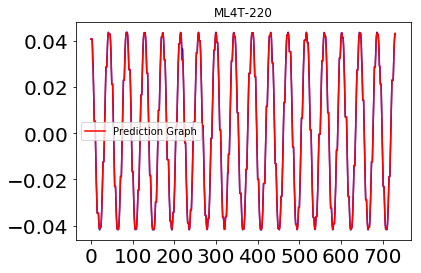

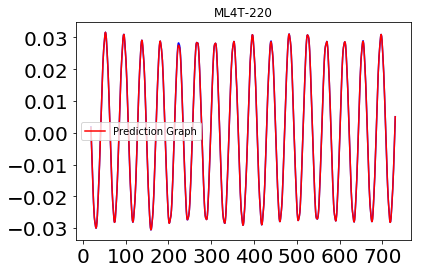

In [628]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(dfTrainingX,dfTrainingY)
predictY=rf.predict(dfTestingX)


randomForest_model_mse=mean_squared_error(predictY,dfTestingY)
randomForest_model_mse
import math
print("Testing MSE is {}".format(math.sqrt(randomForest_model_mse)))
errors = abs(predictions - dfTestingY)
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = 100 * (errors / dfTestingY)

accuracy=100-np.mean(mape)
print(np.mean(mape))
print('Accuracy',round(accuracy,2),'%.')


dfPredictY=pd.DataFrame()
dfPredictY['Y_5']=predictY


print(dfPredictY.head())
ax4=plt.figure()
ax4=plt.gca()


dfTestingY.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax4)
dfPredictY.plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax4)



axPredAvg=plt.figure()
axPredAvg=plt.gca()


dfTestingY.rolling(window=20).mean().plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=axPredAvg)
dfPredictY.rolling(window=20).mean().plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=axPredAvg)



K nearest Neighbours



        Y_5
0  0.040872
1  0.040872
2  0.040872
3  0.040872
4  0.039988


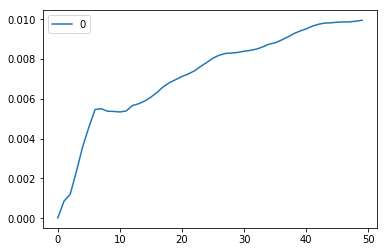

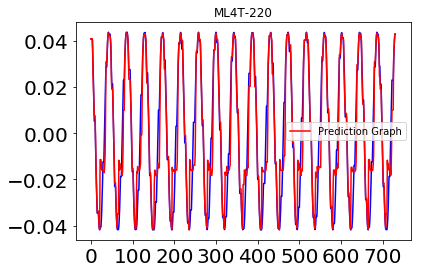

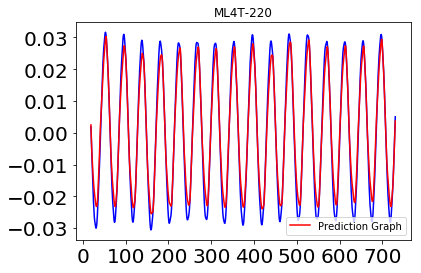

In [629]:
from sklearn import neighbors
from math import sqrt
rmse_val = [] #to store rmse values for different k
for K in range(50):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(dfTrainingX, dfTrainingY)  #fit the model
    predictY=model.predict(dfTestingX) #make prediction on test set
    error = sqrt(mean_squared_error(dfTestingY,predictY)) #calculate rmse
    rmse_val.append(error) #store rmse values
    #print('RMSE value for k= ' , K , 'is:', error)
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()


dfPredictY=pd.DataFrame()
dfPredictY['Y_5']=predictY


print(dfPredictY.head())
ax4=plt.figure()
ax4=plt.gca()


dfTestingY.plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=ax4)
dfPredictY.plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=ax4)



axPredAvg=plt.figure()
axPredAvg=plt.gca()


dfTestingY.rolling(window=20).mean().plot(y='Y_5',label='Original Graph',title=syms[0],fontsize=20,color='blue',ax=axPredAvg)
dfPredictY.rolling(window=20).mean().plot(y='Y_5',label='Prediction Graph',title=syms[0],fontsize=20,color='red',ax=axPredAvg)

